<a href="https://colab.research.google.com/github/JordanFoss/STAT3007_Project/blob/main/Encoder_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 3772, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 3772 (delta 19), reused 36 (delta 12), pack-reused 3722
Receiving objects: 100% (3772/3772), 662.39 MiB | 30.39 MiB/s, done.
Resolving deltas: 100% (604/604), done.
Checking out files: 100% (2803/2803), done.
/content/STAT3007_Project


In [2]:
pip install colorednoise

  Created wheel for colorednoise: filename=colorednoise-1.1.1-cp37-none-any.whl size=3958 sha256=c2add3fb1c22630d712325dd716bf7f99352f1f610b227b9b086de9f8878c582
  Stored in directory: /root/.cache/pip/wheels/84/be/f3/3e7e1c80ebab3f6f0dbd3e34e787b902d2280d66706485fef4
Successfully built colorednoise


In [3]:
import librosa
from librosa import display
import colorednoise as cn
import torch
import numpy as np
from IPython.display import Audio
import glob
from pre_process import *
import os
import torch.optim as optim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor

import scipy
from torchsummary import summary


class NoiseColour:
  White = 0
  Violet = -2
  Blue = -1
  Pink = 1
  Brown = 2

def nosify(samples, noise_level = 1, colour = NoiseColour.White):
  if colour == NoiseColour.White:
    noise = torch.randn_like(samples)
  else:
    noise = torch.from_numpy(cn.powerlaw_psd_gaussian(exponent = colour, size = samples.shape[1])).float()

  scaled_noise = noise * torch.mean(torch.abs(samples)) * noise_level
  
  noisy_samples = samples + scaled_noise
  return noisy_samples

def data_gen(sample, sampling_rate ,duration):
  truncated_sample = truncate_silence(sample)
  truncated_sample = amp_normalisation(truncated_sample)

  total_duration = truncated_sample.shape[0]
  diff_duration = total_duration - (duration * sampling_rate)

  padded_sample = truncated_sample
  if diff_duration < 0:
    padded_sample = pre_pad(truncated_sample, int(duration * sampling_rate))
    
  spectrogram = mel_spectral_decomposition(padded_sample[:int(sampling_rate * duration)], sampling_rate)

  return spectrogram

In [4]:
noisy_spectrograms = []
clean_spectrograms = []
for name in glob.glob('/content/STAT3007_Project/sample-noisy-speech-actor-11/*.wav'):

  clean_name = name.split('/')[-1].split('_')[0]
  noisy_samples, noisy_sampling_rate = librosa.load(name, sr = 16000)
  clean_samples, clean_sampling_rate = librosa.load('./Audio_Speech_Actors_01-24/Male/Actor_11/'+clean_name+'.wav', sr = 16000)

  noisy_data = data_gen(noisy_samples, noisy_sampling_rate, 2)
  clean_data = data_gen(clean_samples, clean_sampling_rate,2)

  noisy_spectrograms.append(noisy_data)
  clean_spectrograms.append(clean_data)
  

In [5]:
X = torch.tensor(noisy_spectrograms)
X = X.reshape(X.shape[0],1,X.shape[1],X.shape[2])
y = torch.tensor(clean_spectrograms)

In [15]:
class Encoder(nn.Module):
  def __init__(self, filters = 16):
    super(Encoder, self).__init__()
    (K, S) = (5, 1)
    self.conv = nn.Sequential(nn.Conv2d(1, filters, kernel_size= 3, stride = 1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size = 2),
                              nn.ReLU(),
                              nn.Conv2d(filters,filters,kernel_size= 3, stride = 1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size = 2),
                              nn.Conv2d(filters,filters,kernel_size= 3, stride = 1),
                              nn.ReLU()
                              )
    
  def forward(self, x):
    x = self.conv(x)
    return x


class Decoder(nn.Module):
  def __init__(self, filters = 16):
    super(Decoder, self).__init__()
    (K, S) = (2, 1)
    self.conv = nn.Sequential(nn.ConvTranspose2d(filters,filters, kernel_size = 3),
                              nn.ReLU(),
                              nn.Upsample(size = (61, 28)),
                              nn.ConvTranspose2d(filters,filters, kernel_size = 3),
                              nn.ReLU(),
                              nn.Upsample(size = (126, 61)),
                              nn.ConvTranspose2d(filters,1, kernel_size = 3),
                              )
    
  def forward(self, x):
    x = self.conv(x)
    return x

class Autoencoder(nn.Module):
  def __init__(self, filters):
    super(Autoencoder,self).__init__()
    self.filters = filters
    self.encoder = Encoder(filters)
    self.decoder = Decoder(filters)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [16]:
test_encoder = Encoder()
test_decoder = Decoder()
test_ae = Autoencoder(16).cuda()

In [17]:
summary(test_ae,(1,128,63))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 126, 61]             160
              ReLU-2          [-1, 16, 126, 61]               0
         MaxPool2d-3           [-1, 16, 63, 30]               0
              ReLU-4           [-1, 16, 63, 30]               0
            Conv2d-5           [-1, 16, 61, 28]           2,320
              ReLU-6           [-1, 16, 61, 28]               0
         MaxPool2d-7           [-1, 16, 30, 14]               0
            Conv2d-8           [-1, 16, 28, 12]           2,320
              ReLU-9           [-1, 16, 28, 12]               0
          Encoder-10           [-1, 16, 28, 12]               0
  ConvTranspose2d-11           [-1, 16, 30, 14]           2,320
             ReLU-12           [-1, 16, 30, 14]               0
         Upsample-13           [-1, 16, 61, 28]               0
  ConvTranspose2d-14           [-1, 16,

In [18]:
class DatasetWrapper(Dataset):
  def __init__(self, X, y):
    self.X, self.y = X, y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]
  
  def change_type(self, dtype):

    return DatasetWrapper(self.X.type(dtype),self.y.type(dtype))
  
  def dataset(self):
    return DatasetWrapper(self.X,self.y)
  
  def get_data(self):
    return self.X, self.y
def train_model(data, net, loss, nepoch ,lr = 0.01, batch_size = -1, use_cuda = False, print_output = True):
  
  # appropriate data type for CPU or GPU
  device = None
  if use_cuda and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    net = net.to(device)
  else:
    dtype = torch.FloatTensor

  optimizer = optim.Adam(net.parameters(), lr = lr)
  data = data.dataset.change_type(dtype)

  if batch_size == -1:
    data_loader = DataLoader(data,
                         batch_size = data.dataset__len__, shuffle = True)
  
  else:
    data_loader = DataLoader(data,
                             batch_size = batch_size, shuffle = True)
    
  for epoch in range(nepoch):
     for X_batch, y_batch in data_loader:
      y_batch = y_batch.reshape(y_batch.shape[0],1,y_batch.shape[1],y_batch.shape[2])
      if use_cuda and device != None:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

      optimizer.zero_grad()

      # since all our values are negative, we convert them to positive
      pred = net(X_batch)
      Rn = loss(pred[:,0,:,:], y_batch[:,0,:,:])
      Rn.backward()
      optimizer.step()
     if print_output:
      print('epoch:', epoch)
      print('loss:',Rn.item())
      print('------------')
  
  print('final loss:', Rn.item())
  
  return net

In [19]:

spectro_data = DatasetWrapper(X,y)
train_size = int(X.shape[0] * 0.7)
test_size = X.shape[0] - train_size

loss = nn.MSELoss()

data_test, data_train = random_split(spectro_data,[test_size,train_size], generator = torch.Generator().manual_seed(10))
nepoch = 100
batch_size = 30

torch.manual_seed(69)
AE = Autoencoder(16)

trained_net = train_model(data_train,AE, loss, nepoch = nepoch,lr = 0.01, batch_size = batch_size, use_cuda = True,print_output = True)

epoch: 0
loss: 200.82748413085938
------------
epoch: 1
loss: 166.5156707763672
------------
epoch: 2
loss: 197.40562438964844
------------
epoch: 3
loss: 122.41118621826172
------------
epoch: 4
loss: 136.5709228515625
------------
epoch: 5
loss: 111.80054473876953
------------
epoch: 6
loss: 110.14813995361328
------------
epoch: 7
loss: 84.90454864501953
------------
epoch: 8
loss: 82.48357391357422
------------
epoch: 9
loss: 95.83207702636719
------------
epoch: 10
loss: 93.06073760986328
------------
epoch: 11
loss: 97.22087860107422
------------
epoch: 12
loss: 119.95518493652344
------------
epoch: 13
loss: 88.3064956665039
------------
epoch: 14
loss: 94.13784790039062
------------
epoch: 15
loss: 103.52973175048828
------------
epoch: 16
loss: 83.80037689208984
------------
epoch: 17
loss: 102.20343017578125
------------
epoch: 18
loss: 86.05894470214844
------------
epoch: 19
loss: 87.17792510986328
------------
epoch: 20
loss: 113.02751922607422
------------
epoch: 21
loss:

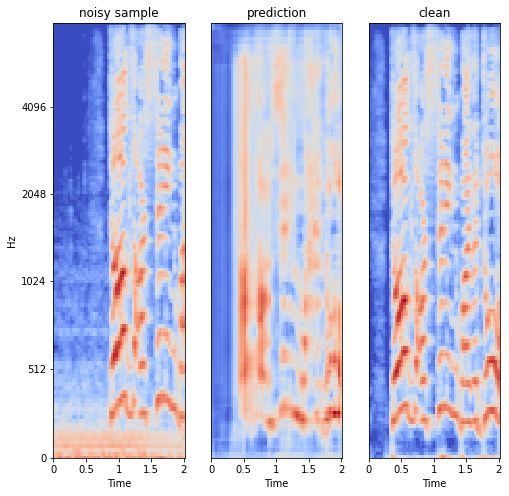

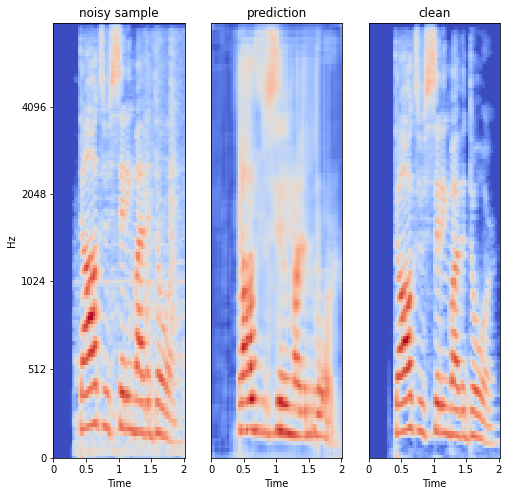

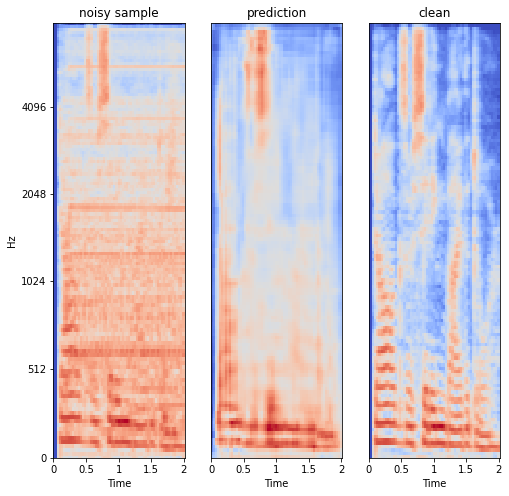

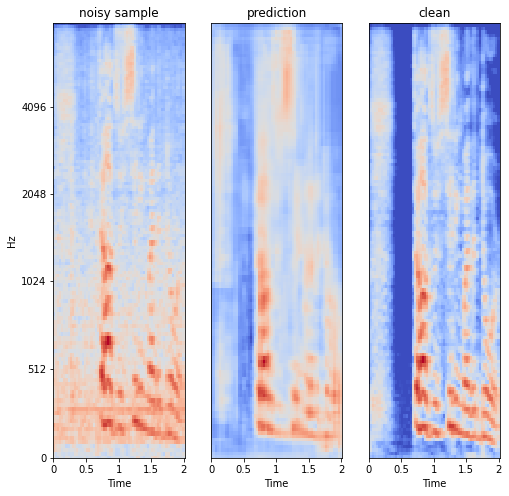

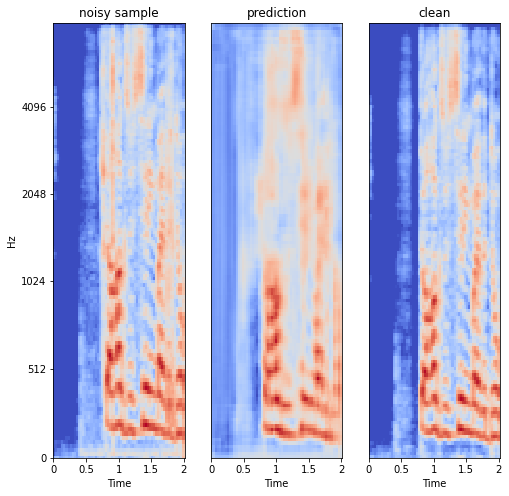

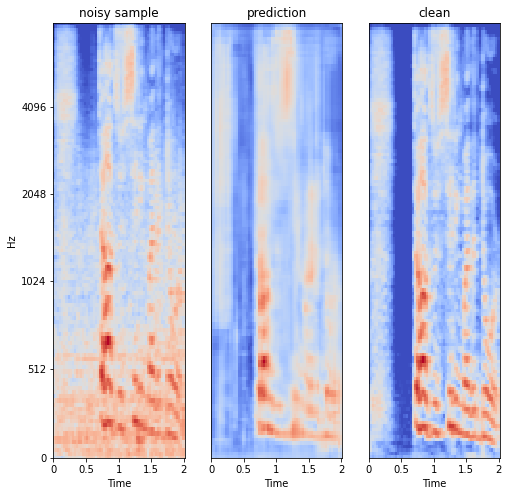

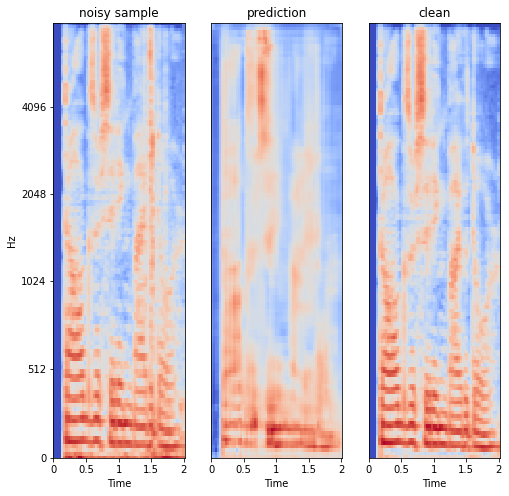

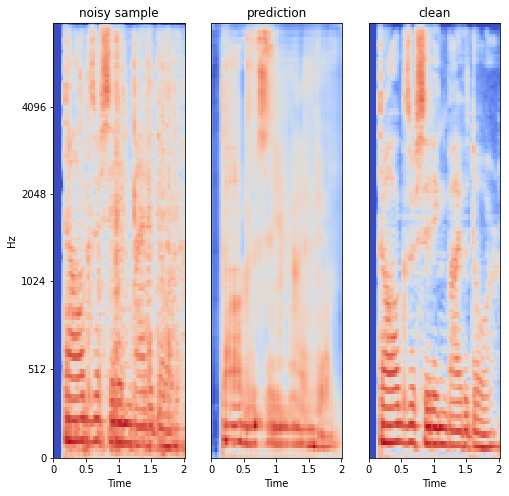

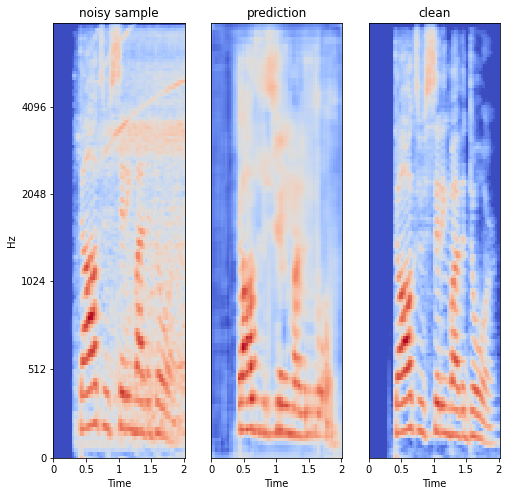

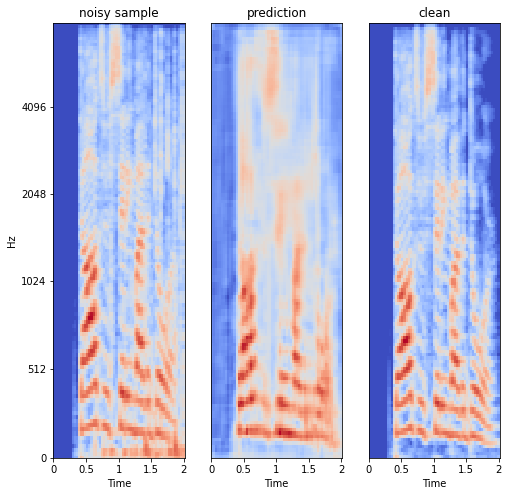

In [20]:

X_test, y_test = data_test.dataset.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
trained_net = trained_net.to(torch.device('cpu'))
y_pred = trained_net(X_test)

for i in range(10):
    plt.figure(figsize = (8,8))
    plt.subplot2grid((1,3),(0,0))
    librosa.display.specshow(X_test[i,0].detach().numpy(), y_axis='mel', fmax=8000, x_axis='time', sr =16000);
    plt.title('noisy sample')

    plt.subplot2grid((1,3),(0,1))
    librosa.display.specshow(y_pred[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('prediction')


    ax = plt.subplot2grid((1,3),(0,2))
    librosa.display.specshow(y_test[i].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('clean')
    plt.show()

# next step: use encoder to classify